# Example of field-free impulsive alignment of OCS molecule

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import constants

from richmol import (
    POL_X_FIELD2_INVCM,
    CartTensor,
    RotStates,
    propagate_expm,
    propagate_expokit,
)

Define molecule and its properties, compute rotational states and matrix elements.

In [2]:
xyz = (
    "C",  0.0,  0.0,  -0.522939783141,
    "O",  0.0,  0.0,  -1.680839357,
    "S",  0.0,  0.0,  1.037160128,
)

# rotational states
jmax = 20
states = RotStates.from_geometry(jmax, xyz)

# molecular-frame dipole moment (in au)
dip = [0, 0, -0.31093]

# molecular-frame polarizability tensor (in au)
pol = [
    [25.5778097, 0, 0],
    [0, 25.5778097, 0],
    [0, 0, 52.4651140],
]

# rotational matrix elements of laboratory-frame
# dipole and polarizability tensors
dip = CartTensor(states, dip)
pol = CartTensor(states, pol)


Compute rigid-rotor solutions using molecular geometry as input
Cartesian units: angstrom, conversion to Angstrom: 1
  Atom           Mass (u)              X (Å)              Y (Å)              Z (Å)
     C    12.000000000000     0.000000000000     0.000000000000    -0.522939783141
     O    15.994914619260     0.000000000000     0.000000000000    -1.680839357000
     S    31.972071173540     0.000000000000     0.000000000000     1.037160128000
Symmetry group: c1
Molecule is linear
G-matrix (cm^-1):
 [[0.40687878 0.         0.        ]
 [0.         0.40687878 0.        ]
 [0.         0.         0.        ]]


/Users/yachmena/.venvs/myenv/lib/python3.13/site-packages/richmol/asymtop.py:220: RuntimeWarning: divide by zero encountered in divide
  d = np.where(sv > G_SING_TOL, 1 / sv, 0)


solve for J = 0 and symmetry A ...
solve for J = 1 and symmetry A ...
solve for J = 2 and symmetry A ...
solve for J = 3 and symmetry A ...
solve for J = 4 and symmetry A ...
solve for J = 5 and symmetry A ...
solve for J = 6 and symmetry A ...
solve for J = 7 and symmetry A ...
solve for J = 8 and symmetry A ...
solve for J = 9 and symmetry A ...
solve for J = 10 and symmetry A ...
solve for J = 11 and symmetry A ...
solve for J = 12 and symmetry A ...
solve for J = 13 and symmetry A ...
solve for J = 14 and symmetry A ...
solve for J = 15 and symmetry A ...
solve for J = 16 and symmetry A ...
solve for J = 17 and symmetry A ...
solve for J = 18 and symmetry A ...
solve for J = 19 and symmetry A ...
solve for J = 20 and symmetry A ...


Initialize field.

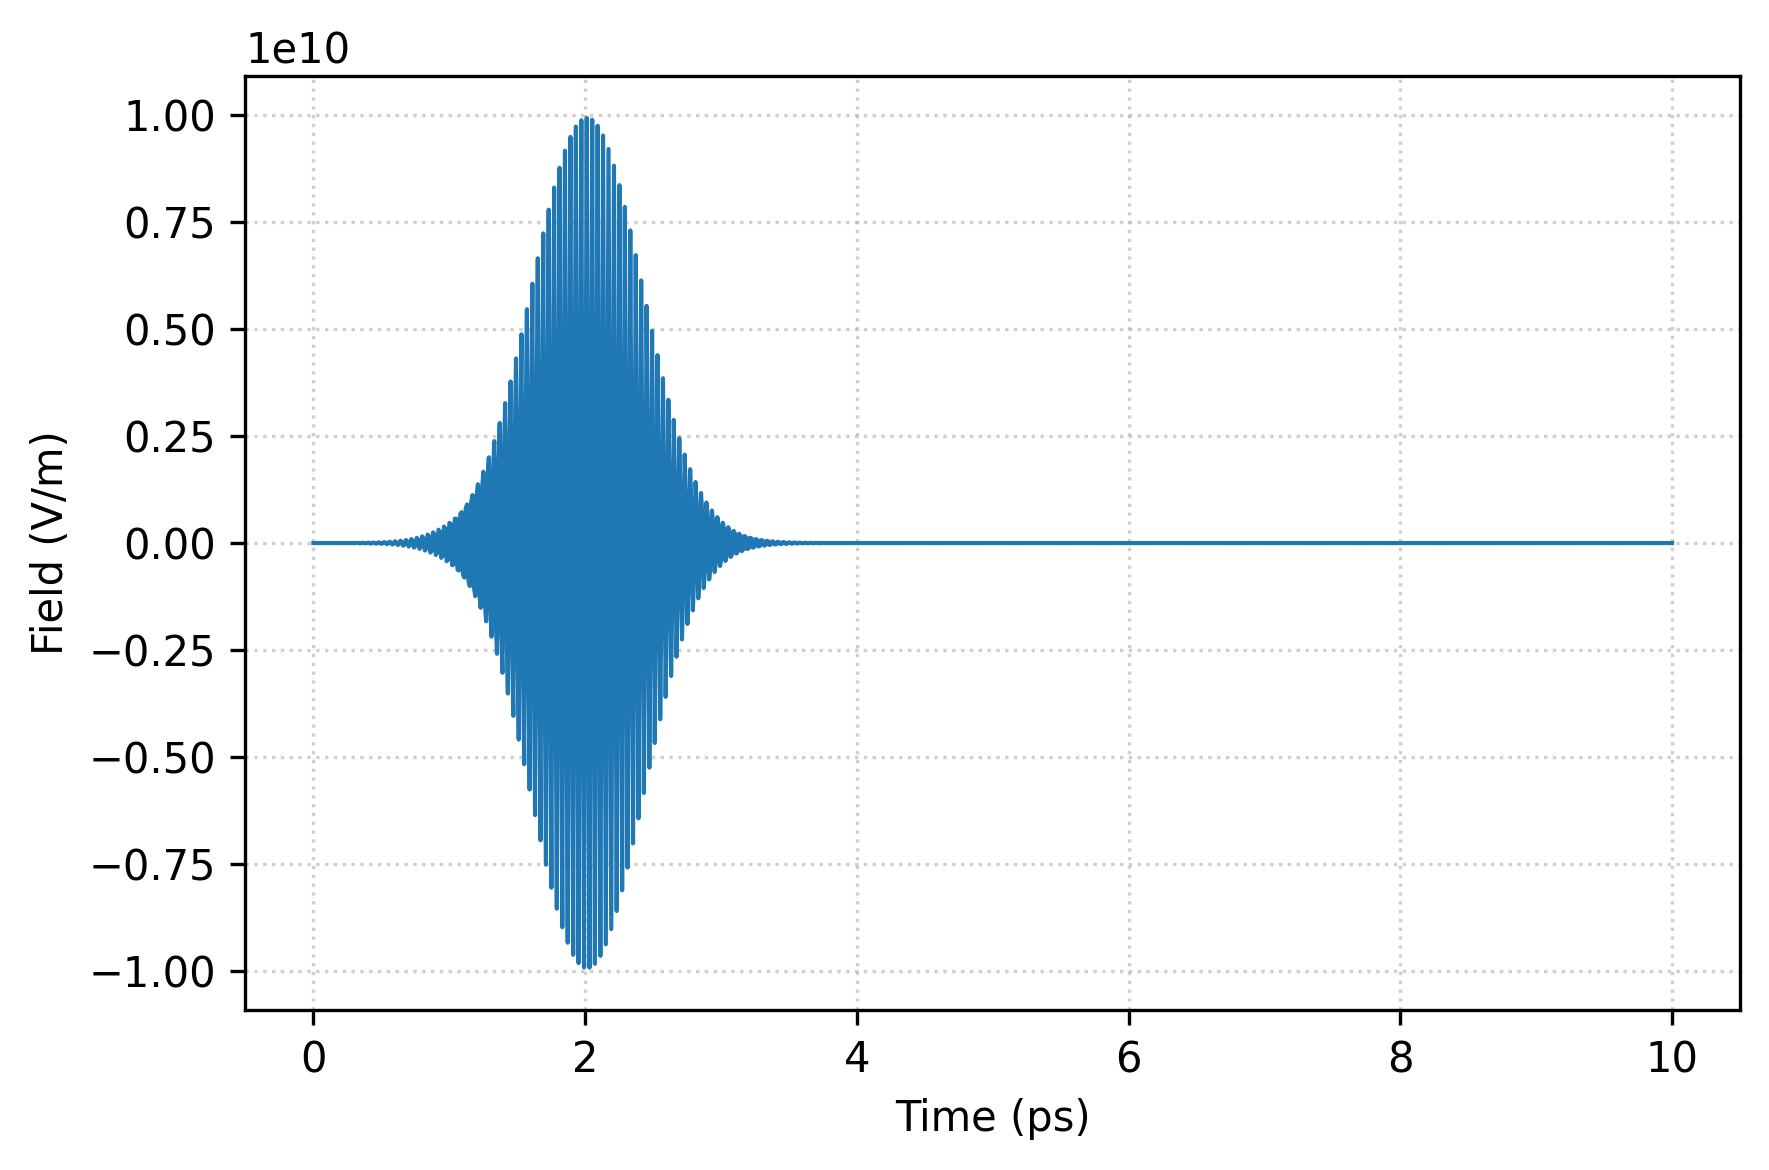

In [3]:
def field_z(time, fwhm, t0=None):
    nm = 1e-9
    omega = 800 * nm  # in nm
    omega = 2 * np.pi * constants.speed_of_light / omega * 1e-12  # in 1/ps
    if t0 is None:
        t0 = 2.5 * fwhm / 2
    amp = 1e10  # in V/m
    return (
        amp * np.exp(-4 * np.log(2) * (time - t0) ** 2 / fwhm**2) * np.cos(omega * time)
    )


plt.figure(figsize=(6, 4), dpi=300)

t = np.linspace(0, 10, 1000)
plt.plot(t, field_z(t, fwhm=1, t0=2), linewidth=1)
plt.xlabel("Time (ps)")
plt.ylabel("Field (V/m)")
plt.grid(True, linestyle=":", alpha=0.6)
plt.yticks(fontsize=10)
plt.tight_layout()

Solve TDSE for OCS rotations in field.

In [4]:
# initial wavepacket: J=0 state
c0 = np.zeros(states.mat().shape[0], dtype=np.complex128)
c0[0] = 1.0

field_au = constants.value("atomic unit of electric field")
field_func = lambda t: np.array([0, 0, field_z(t, fwhm=1, t0=2) / field_au])

time, c_t = propagate_expokit(
    states,
    [pol],
    [-0.5 * POL_X_FIELD2_INVCM],
    field_func=field_func,
    t0=0,
    t1=100,
    dt=0.01,
    time_unit="ps",
    c0=c0,
)

# time, c_t = propagate_expm(
#     states,
#     [pol],
#     [-0.5 * POL_X_FIELD2_INVCM],
#     field_func=field_func,
#     t0=0,
#     t1=100,
#     dt=0.01,
#     time_unit="ps",
#     c0=c0,
# )

 happy breakdown: mbrkdwn =           1  h =   1.4590392508412126E-010
 happy breakdown: mbrkdwn =           1  h =   3.5400225117672573E-014
 happy breakdown: mbrkdwn =           1  h =   2.2669610918794495E-010
 happy breakdown: mbrkdwn =           1  h =   4.9405440818137537E-013
 happy breakdown: mbrkdwn =           1  h =   3.5012077647711019E-010
 happy breakdown: mbrkdwn =           1  h =   2.1176112397566507E-012
 happy breakdown: mbrkdwn =           1  h =   5.3751036511093248E-010
 happy breakdown: mbrkdwn =           1  h =   6.3727052241219291E-012
 happy breakdown: mbrkdwn =           1  h =   8.2025389333903024E-010
 happy breakdown: mbrkdwn =           1  h =   1.6094654328821704E-011
 happy breakdown: mbrkdwn =           1  h =   1.2442238578583582E-009
 happy breakdown: mbrkdwn =           1  h =   3.6550890915558440E-011
 happy breakdown: mbrkdwn =           1  h =   1.8759993382677594E-009
 happy breakdown: mbrkdwn =           1  h =   7.7225724011824225E-011
 happy

Plot state populations.

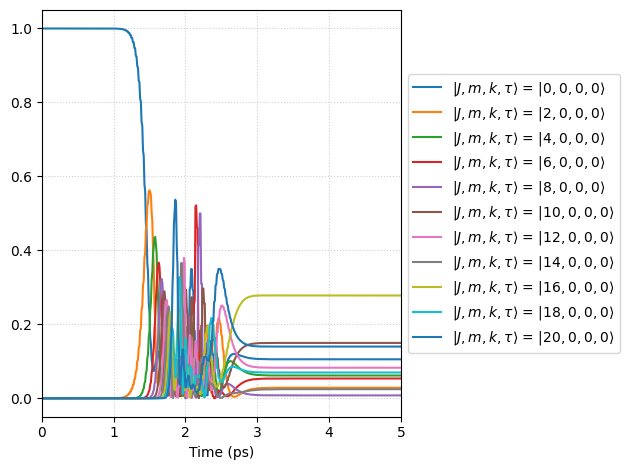

In [5]:
# state populations
pop_t = np.abs(c_t) ** 2

# states with nonzero populations
state_ind = np.any(np.abs(pop_t) > 1e-2, axis=0).nonzero()[0]
state_qua = [
    f"$|J,m,k,\\tau\\rangle$ = $|{j}, {m}, {k}, {tau}\\rangle$" for (j, m, k, tau, *_) in states.quanta[state_ind]
]

plt.plot(time, pop_t[:, state_ind], label=state_qua)
plt.xlim([0, 5])

plt.xlabel("Time (ps)")
plt.grid(True, linestyle=":", alpha=0.6)
plt.legend(fontsize=10, loc="center left", bbox_to_anchor=(1, 0.5))
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

Compute and plot alignment functions $\cos\theta$, $\cos\theta_{2D}$, $\cos^2\theta$, and $\cos^2\theta_{2D}$, using Monte-Carlo approach.

In [6]:
coefs = c_t[::20]

expval = []
nbatches = 10
for ibatch, c in enumerate(np.split(coefs, nbatches)):
    print(f"batch {ibatch+1}/{nbatches}")
    expval.append(states.mc_costheta(c.T))
cost, cost_sq, cost2d, cost2d_sq = np.concatenate(expval, axis=-1)

batch 1/10
remark: compute reduced rotational density using _rot_dens_wp1
batch 2/10
remark: compute reduced rotational density using _rot_dens_wp1
batch 3/10
remark: compute reduced rotational density using _rot_dens_wp1
batch 4/10
remark: compute reduced rotational density using _rot_dens_wp1
batch 5/10
remark: compute reduced rotational density using _rot_dens_wp1
batch 6/10
remark: compute reduced rotational density using _rot_dens_wp1
batch 7/10
remark: compute reduced rotational density using _rot_dens_wp1
batch 8/10
remark: compute reduced rotational density using _rot_dens_wp1
batch 9/10
remark: compute reduced rotational density using _rot_dens_wp1
batch 10/10
remark: compute reduced rotational density using _rot_dens_wp1


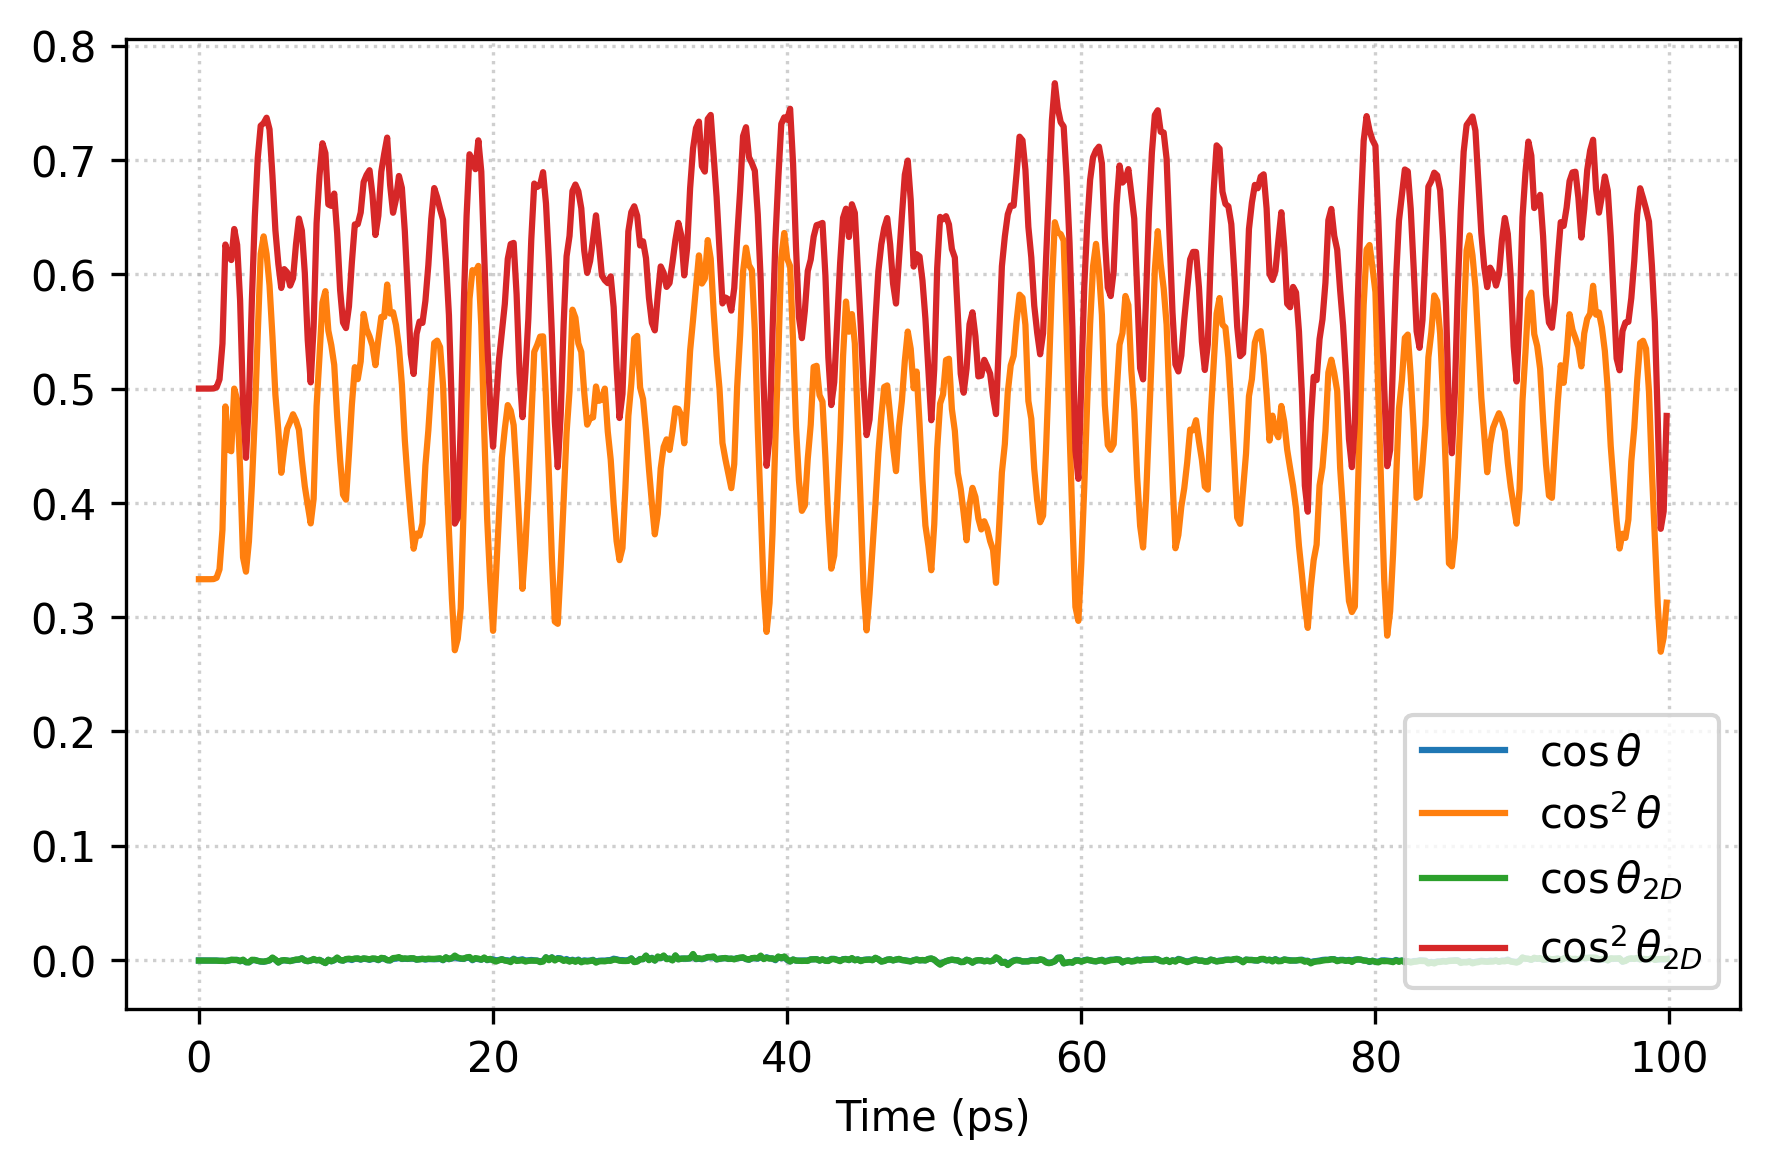

In [7]:
t = time[::20]

plt.figure(figsize=(6, 4), dpi=300)
plt.plot(t, cost, linewidth=1.5, label="$\\cos\\theta$")
plt.plot(t, cost_sq, linewidth=1.5, label="$\\cos^2\\theta$")
plt.plot(t, cost2d, linewidth=1.5, label="$\\cos\\theta_{2D}$")
plt.plot(t, cost2d_sq, linewidth=1.5, label="$\\cos^2\\theta_{2D}$")
plt.xlabel("Time (ps)")
plt.grid(True, linestyle=":", alpha=0.6)
plt.legend(fontsize=10, loc="lower right")
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()